In [1]:
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
# !chmod +x mini.sh
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py38" --user

In [2]:
# !python --version

In [3]:
import warnings
import tensorflow as tf
import tensorflow.keras as kr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical

BATCH = 128
SEED = 57
EPOCHS = 50
NUM_CLASSES = 10
PATIENCE = 10

warnings.filterwarnings('ignore')
tf.random.set_seed(SEED)

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
class ConvolutionBlock(kr.layers.Layer):
  def __init__(self, filters, pool=False):
    super().__init__()
    self.conv = kr.layers.Conv2D(filters=filters, kernel_size=3, padding='same')
    self.bn = kr.layers.BatchNormalization()
    self.relu = kr.layers.ReLU()
    self.pool = kr.layers.MaxPool2D() if pool else None

  def call(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    if self.pool: x = self.pool(x)
    return x

In [6]:
class ResidualBlock(kr.layers.Layer):
  def __init__(self, filters):
    super().__init__()
    self.conv_b1 = ConvolutionBlock(filters)
    self.conv_b2 = ConvolutionBlock(filters)
    self.add = kr.layers.Add()
  
  def call(self, x):
    return self.add([self.conv_b2(self.conv_b1(x)), x])

In [7]:
class Resnet9(kr.models.Model):
  def __init__(self, num_classes):
    super().__init__()
    self.augmentations = [
        kr.layers.RandomFlip('horizontal'),
        kr.layers.RandomRotation(0.1, fill_mode='reflect')
    ]
    self.conv_b1 = ConvolutionBlock(64)
    self.conv_b2 = ConvolutionBlock(128, pool=True)
    self.resd_b1 = ResidualBlock(128)
    self.conv_b3 = ConvolutionBlock(256, pool=True)
    self.conv_b4 = ConvolutionBlock(512, pool=True)
    self.resd_b2 = ResidualBlock(512)
    self.pool = kr.layers.MaxPool2D()
    self.flatten = kr.layers.Flatten()
    self.dropout = kr.layers.Dropout(0.2)
    self.dense = kr.layers.Dense(num_classes)
    self.softmax = kr.layers.Softmax()

  def call(self, x, training=False):
    for augmentation in self.augmentations: x = augmentation(x)
    x = self.conv_b1(x)
    x = self.conv_b2(x)
    x = self.resd_b1(x)
    x = self.conv_b3(x)
    x = self.conv_b4(x)
    x = self.resd_b2(x)
    x = self.pool(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.dense(x)
    x = self.softmax(x)
    return x

In [8]:
model = Resnet9(NUM_CLASSES)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [10]:
(xtr, ytr), (xvl, yvl) = kr.datasets.cifar10.load_data()

In [11]:
xtr.shape, xvl.shape, ytr.shape, yvl.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [12]:
xtr = xtr.astype('float32') / 255
xvl = xvl.astype('float32') / 255

In [13]:
ytr = to_categorical(ytr, num_classes=10)
yvl = to_categorical(yvl, num_classes=10)

In [14]:
xtr.shape, xvl.shape, ytr.shape, yvl.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [15]:
early_stopping = kr.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)

In [16]:
%%time
tranings = model.fit(xtr, ytr, validation_data=(xvl, yvl), epochs=EPOCHS, shuffle=True, batch_size=BATCH, verbose=True, callbacks=[early_stopping])

Epoch 1/50
391/391 [==============================] - 32s 70ms/step - loss: 1.9609 - accuracy: 0.4187 - val_loss: 3.1003 - val_accuracy: 0.1452
Epoch 2/50
391/391 [==============================] - 27s 70ms/step - loss: 1.3108 - accuracy: 0.5825 - val_loss: 1.1835 - val_accuracy: 0.6140
Epoch 3/50
391/391 [==============================] - 26s 65ms/step - loss: 1.0821 - accuracy: 0.6501 - val_loss: 1.1296 - val_accuracy: 0.6592
Epoch 4/50
391/391 [==============================] - 27s 68ms/step - loss: 0.9255 - accuracy: 0.6959 - val_loss: 1.0655 - val_accuracy: 0.6632
Epoch 5/50
391/391 [==============================] - 26s 66ms/step - loss: 0.8328 - accuracy: 0.7219 - val_loss: 0.7764 - val_accuracy: 0.7395
Epoch 6/50
391/391 [==============================] - 26s 66ms/step - loss: 0.7426 - accuracy: 0.7500 - val_loss: 0.6711 - val_accuracy: 0.7747
Epoch 7/50
391/391 [==============================] - 26s 66ms/step - loss: 0.6716 - accuracy: 0.7745 - val_loss: 0.7860 - val_accuracy:

In [17]:
model.evaluate(xvl, yvl, batch_size=BATCH)

79/79 [==============================] - 2s 20ms/step - loss: 0.4926 - accuracy: 0.8756


[0.49256792664527893, 0.8755999803543091]

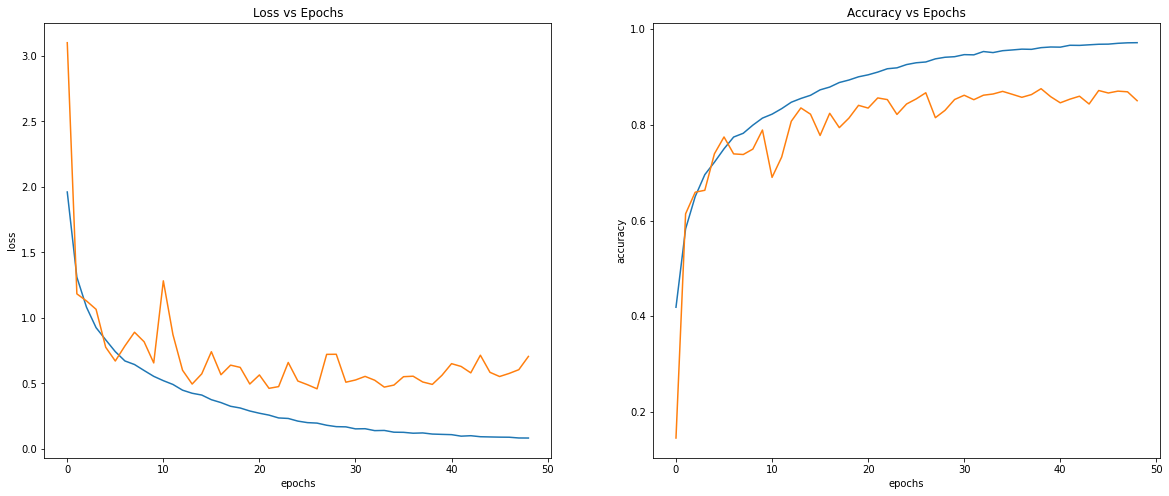

In [18]:
_, axes = plt.subplots(ncols=2, figsize=(20, 8))
axes[0].plot(tranings.history['loss'])
axes[0].plot(tranings.history['val_loss'])
axes[0].set_title('Loss vs Epochs')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')

axes[1].plot(tranings.history['accuracy'])
axes[1].plot(tranings.history['val_accuracy'])
axes[1].set_title('Accuracy vs Epochs')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accuracy')
plt.show()